<a href="https://colab.research.google.com/github/Ivan137950/Stocks/blob/main/Making_Dataset_of_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Зададим модуль для считывания данных с портала мосбиржи

In [1]:
import requests
from datetime import datetime, timedelta
import pandas as pd


In [2]:
j = requests.get('https://iss.moex.com/iss/securities.json?q=Yandex').json()
data = [{k : r[i] for i, k in enumerate(j['securities']['columns'])} for r in j['securities']['data']]
print(pd.DataFrame(data))

          id         secid   shortname     regnumber  \
0  427994427          YDEX      ЯНДЕКС  1-01-16777-A   
1  429364997          YDH5   YDEX-3.25          None   
2  430418817          YDM5   YDEX-6.25          None   
3      69458          YNDX  Yandex clA          None   
4  428928395          YDU4   YDEX-9.24          None   
5  428928397          YDZ4  YDEX-12.24          None   
6  413635407  XS2126193379     YNDX-25          None   

                             name          isin  is_traded  emitent_id  \
0                    МКПАО ЯНДЕКС  RU000A107T19          1       15523   
1   Фьючерсный контракт YDEX-3.25          None          1       15523   
2   Фьючерсный контракт YDEX-6.25          None          1       15523   
3    PLLC Yandex N.V. class A shs  NL0009805522          0        6822   
4   Фьючерсный контракт YDEX-9.24          None          0       15523   
5  Фьючерсный контракт YDEX-12.24          None          0       15523   
6       Yandex N.V. 0.75 03/03/25

Проверим работу, выведем графики цен акций четырех компаний


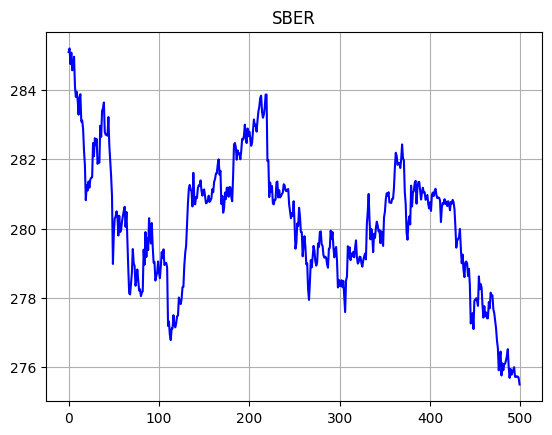

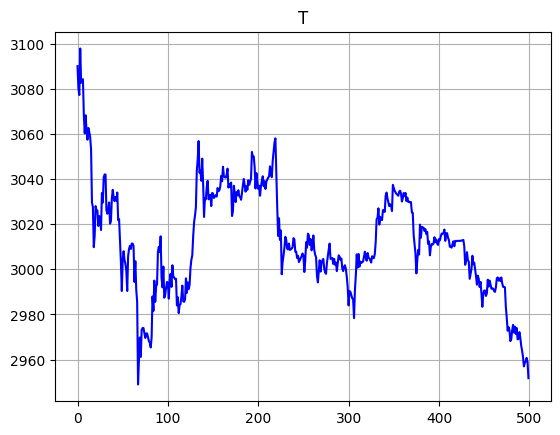

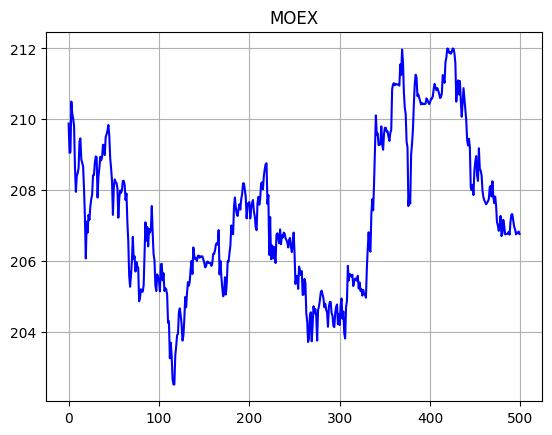

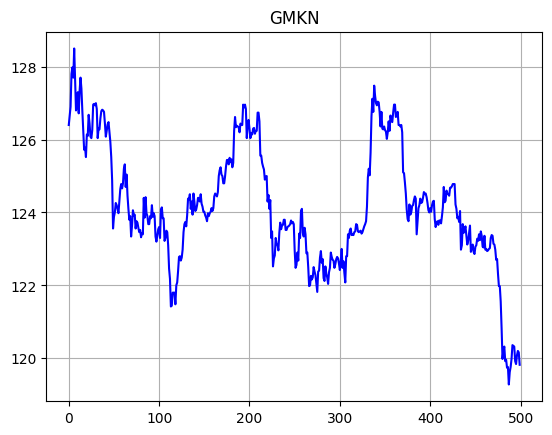

In [3]:
from matplotlib import pyplot as plt

codes = ['SBER', 'T', 'MOEX', 'GMKN']
for code in codes:
  j = requests.get('http://iss.moex.com/iss/engines/stock/markets/shares/securities/' + code + '/candles.json?from=2025-01-19till=2025-01-20').json()
  data = [{k : r[i] for i, k in enumerate(j['candles']['columns'])} for r in j['candles']['data']]
  frame = pd.DataFrame(data)
  plt.plot(list(frame['close']), 'b')
  plt.title(code)
  plt.grid()
  plt.savefig(code + ".png")
  plt.show()
  # print(data)

In [4]:
pd.DataFrame(data)

,open,close,high,low,value,volume,begin,end
0,126.40,126.40,126.40,126.40,17160064.0,135760,2025-01-20 09:50:00,2025-01-20 09:59:59
1,126.30,126.66,127.00,126.10,280901521.6,2219470,2025-01-20 10:00:00,2025-01-20 10:09:59
2,126.64,126.90,126.90,125.70,310961539.4,2463210,2025-01-20 10:10:00,2025-01-20 10:19:59
3,126.88,127.80,127.98,126.74,256219371.0,2013400,2025-01-20 10:20:00,2025-01-20 10:29:59
4,127.86,127.98,128.48,127.44,574695642.0,4489250,2025-01-20 10:30:00,2025-01-20 10:39:59
...,...,...,...,...,...,...,...,...
495,119.90,119.84,120.26,119.82,16715371.6,139320,2025-01-27 20:20:00,2025-01-27 20:29:59
496,119.90,120.08,120.28,119.90,15764714.8,131210,2025-01-27 20:30:00,2025-01-27 20:39:59
497,120.12,120.20,120.24,120.06,3376180.8,28100,2025-01-27 20:40:00,2025-01-27 20:49:59
498,120.18,120.16,120.24,120.08,5597364.8,46580,2025-01-27 20:50:00,2025-01-27 20:59:59


Выше были примеры работы с ***MOEX*** при помощи модуля *reqest*. Теперь сделем датасеты для каждой из копаний.**API Moex** ограничивает количество
возвращаемых данных (не более 500, что явно мало для обучения модели), поэтому придётся делать много запросов.

In [5]:
def concat_data(stocks: str) -> pd.DataFrame: #Данные по акциям stocks за последние 4 года (208 недель)
  today = datetime.now()
  #  - timedelta(days=1)
  df = pd.DataFrame()
  for _ in range(208):
    yesterday = today - timedelta(days=7)

    today_str = str(today)[:10]
    yesterday_str = str(yesterday)[:10]

    j = requests.get('http://iss.moex.com/iss/engines/stock/markets/shares/securities/' + stocks + '/candles.json?from=' + yesterday_str + '&till=' + today_str).json()
    data = [{k : r[i] for i, k in enumerate(j['candles']['columns'])} for r in j['candles']['data']]
    frame = pd.DataFrame(data)

    today = yesterday
    df = pd.concat([df, pd.DataFrame(data)])
  return df

In [6]:
codes = ['SBER', 'T', 'MOEX', 'YNDX', 'GMKN', 'AFLT', 'BANE', 'MSNG', 'LENT', 'LKOH', 'LVHK', 'MRSB', 'FEES']

In [7]:
import numpy as np

In [8]:
frames = {}
for code in codes:
  frame = concat_data(code)
  # if len(frame) > 8e5:
  frames[code] = np.array(list(frame['close'])[::-1])
  print(code)

SBER
T
MOEX
YNDX
GMKN
AFLT
BANE
MSNG
LENT
LKOH
LVHK
MRSB
FEES


Перекинем данные в файлы

In [9]:
for code in codes: #В качестве входных данных будут приниматься значения акций
  with open(code + '_Data.txt', 'w') as f:
    for price in frames[code]:
      f.write(str(price) + '\n')

Есть несколько вариантов, как строить наборы лейблов.
1.   Хочу узнать, будет ли в ближайшем будущем акция дороже, чем сейчас (например, подорожают ли они на не менее чем 2% в ближайшие 160 измерений или же за 20 часов), т.е. будет ли ***x[i] + 0.02 * x[i] < max(x[i+1, i+100])***
2. Наступит ли ***продолжительный*** период в ***ближайшем будущем***, когда акции станут дороже, чем сейчас? Допустим, мы будем под "***ближайшем будущем***" рассматривать 160 измерений, а под "***продолжительным периодом***" будем подразумевать период длительностью хотя бы 18 измерений.




In [10]:
for code in codes: #строим лейблы по первой метрике
  with open(code + '_label_first_metric.txt', 'w') as f:
    frame = frames[code]
    for i in range(len(frame) - 160):
      f.write(f'{1 if 1.02 * frame[i] < max(frame[i+1:i+160]) else 0}' + '\n')

In [11]:
def max_len(array: float, x: float) -> int:
  flag = 0
  maximum = 0
  for i in range(len(array)):
    if array[i] - x > 0:
      flag += 1
      if flag > maximum:
        maximum = flag
    else:
      flag = 0
  return maximum

In [12]:
for code in codes: #строим лейблы по второй метрике
  with open(code + '_label_second_metric.txt', 'w') as f:
    frame = frames[code]
    minimums = []
    for i in range(len(frame) - 160):
      minimums.append(max_len(frame[i + 1 : i + 160], frame[i]))
      f.write(f'{1 if minimums[i] >= 18 else 0}' + '\n')

In [13]:
import os

def move_all_to_dir(name_of_dir: str):
  os.system('mkdir ' + name_of_dir)
  codes = ['SBER', 'T', 'MOEX', 'YNDX', 'GMKN', 'AFLT', 'BANE', 'MSNG', 'LENT', 'LKOH', 'LVHK', 'MRSB', 'FEES']
  for code in codes:
    file_name = code + '_' + name_of_dir + '.txt'
    print(file_name)
    os.system("mv " + file_name + r" " + name_of_dir)


In [14]:
names_of_dirs = ['Data' ,'label_first_metric' ,'label_second_metric']
for name in names_of_dirs:
  move_all_to_dir(name)

SBER_Data.txt
T_Data.txt
MOEX_Data.txt
YNDX_Data.txt
GMKN_Data.txt
AFLT_Data.txt
BANE_Data.txt
MSNG_Data.txt
LENT_Data.txt
LKOH_Data.txt
LVHK_Data.txt
MRSB_Data.txt
FEES_Data.txt
SBER_label_first_metric.txt
T_label_first_metric.txt
MOEX_label_first_metric.txt
YNDX_label_first_metric.txt
GMKN_label_first_metric.txt
AFLT_label_first_metric.txt
BANE_label_first_metric.txt
MSNG_label_first_metric.txt
LENT_label_first_metric.txt
LKOH_label_first_metric.txt
LVHK_label_first_metric.txt
MRSB_label_first_metric.txt
FEES_label_first_metric.txt
SBER_label_second_metric.txt
T_label_second_metric.txt
MOEX_label_second_metric.txt
YNDX_label_second_metric.txt
GMKN_label_second_metric.txt
AFLT_label_second_metric.txt
BANE_label_second_metric.txt
MSNG_label_second_metric.txt
LENT_label_second_metric.txt
LKOH_label_second_metric.txt
LVHK_label_second_metric.txt
MRSB_label_second_metric.txt
FEES_label_second_metric.txt


Создадим итоговую папку DATA со всеми данными

In [15]:
final_dir = 'DATA'
os.system('mkdir ' + final_dir)
for name in names_of_dirs:
  os.system("mv " + name + r" " + final_dir)

Сжатие до zip файла и скачивание итогового результата

In [16]:
import shutil
shutil.make_archive(final_dir, 'zip', final_dir)

'/content/DATA.zip'

In [17]:
from google.colab import files
files.download("/content/DATA.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>